## Rental Inventory Statistics

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import hvplot.pandas
from api_keys import maptiler_apikey

In [162]:
# Create a function to clean the CSV file for Manhattan and desired date range
def clean_dataframe(df):

    # Use the melt function to unpivot the DataFrame and create a single column for dates
    clean_df = df.melt(id_vars=['areaName', 'Borough', 'areaType'], var_name='Date', value_name='Inventory')
    
    # Narrow the DataFrame to Manhattan
    clean_manhattan_df = clean_df[(clean_df['Borough'] == 'Manhattan')]

    # Loop through the DataFrame to search for desired date range and append to empty list
    row_range = []
    for index, row in clean_manhattan_df.iterrows():
        if row['Date'][:4] == '2018' or row['Date'][:4] == '2019' or row['Date'][:4] == '2020' or row['Date'][:4] == '2021' or row['Date'][:4] == '2022':
            row_range.append(row)

    # Create DataFrame from list
    final_df = pd.DataFrame(row_range).reset_index(drop=True)

    # Convert 'Date' column to datetime format
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    
    return final_df

In [163]:
# Import CSV for rental inventory in NYC and create a DataFrame
csvpath_rent = "Resources/rentalInventory_All.csv"
rental_inventory_df = pd.read_csv(csvpath_rent)

# Use the function to narrow the DataFrame for the desired location and dates
rent_manhattan_inv = clean_dataframe(rental_inventory_df)

# Keep only the 'neighborhood' areaType
rent_manhattan_inv = rent_manhattan_inv[rent_manhattan_inv['areaType'] == 'neighborhood'].reset_index(drop=True)

# Display new DataFrame
rent_manhattan_inv.head()

,areaName,Borough,areaType,Date,Inventory
0,Battery Park City,Manhattan,neighborhood,2018-01-01,209
1,Central Harlem,Manhattan,neighborhood,2018-01-01,657
2,Central Park South,Manhattan,neighborhood,2018-01-01,75
3,Chelsea,Manhattan,neighborhood,2018-01-01,895
4,Chinatown,Manhattan,neighborhood,2018-01-01,62


### Plotting Average Rent Sales on a Map

In [16]:
neighborhoods = rent_manhattan_inv['areaName'].unique()
found_lat_long = {}
lat_long_notfound = []

for neighborhood in neighborhoods:

    # Done to remove '/' from 'Stuyvesant Town/PCV'
    if '/' in neighborhood:
        neighborhood = neighborhood.replace('/', ' ')

    # Initialize neighborhood for API search
    query = f'{neighborhood}, Manhattan'
    
    # Set base URL
    base_url = f"https://api.maptiler.com/geocoding/{query}.json?key={maptiler_apikey}"

    # Make a GET request and change it to JSON
    name_address = requests.get(base_url).json()

    try:
        # Check if the location found by the GET request is for Manhattan
        if (', '.join(name_address['features'][0]['place_name'].split(', ')[0:2])) == query:

            # Extract the coordinates and assign to the dictionary
            found_lat_long[neighborhood] = name_address['features'][0]['geometry']['coordinates']
            print(f"{query} was found!")
        else:
            # Assign query name to a list of neighborhoods not found
            print(f"{query} did not match")
            lat_long_notfound.append(query)
    except:
        print(f"{query} was not found")
        lat_long_notfound.append(query)
        pass

found_lat_long


Battery Park City, Manhattan was found!
Central Harlem, Manhattan did not match
Central Park South, Manhattan did not match
Chelsea, Manhattan was found!
Chinatown, Manhattan was found!
Civic Center, Manhattan was found!
East Harlem, Manhattan was found!
East Village, Manhattan was found!
Financial District, Manhattan was found!
Flatiron, Manhattan did not match
Gramercy Park, Manhattan was found!
Greenwich Village, Manhattan was found!
Hamilton Heights, Manhattan was found!
Inwood, Manhattan was found!
Little Italy, Manhattan was found!
Lower East Side, Manhattan was found!
Marble Hill, Manhattan was found!
Midtown, Manhattan was found!
Midtown East, Manhattan was found!
Midtown South, Manhattan was found!
Midtown West, Manhattan did not match
Morningside Heights, Manhattan was found!
Nolita, Manhattan did not match
Roosevelt Island, Manhattan was found!
Soho, Manhattan did not match
Stuyvesant Town PCV, Manhattan did not match
Tribeca, Manhattan was found!
Upper East Side, Manhattan 

{'Battery Park City': [-74.0169370919466, 40.71101673544539],
 'Chelsea': [-74.0015284717083, 40.746490628528385],
 'Chinatown': [-73.99625055491924, 40.716491497942705],
 'Civic Center': [-74.00240421295166, 40.71367933109386],
 'East Harlem': [-73.94250009208918, 40.79472223506761],
 'East Village': [-73.98736137896776, 40.729269020403876],
 'Financial District': [-74.00927100330591, 40.70766832644719],
 'Gramercy Park': [-73.98676768876612, 40.7379753607984],
 'Greenwich Village': [-73.99656604975462, 40.7319804282054],
 'Hamilton Heights': [-73.95006190985441, 40.82414516746835],
 'Inwood': [-73.92049491405487, 40.86925797610624],
 'Little Italy': [-73.99821527302265, 40.71927305271932],
 'Lower East Side': [-73.98680582642555, 40.71593573211237],
 'Marble Hill': [-73.91042925417423, 40.87629833454393],
 'Midtown': [-73.98478008806705, 40.755116903906696],
 'Midtown East': [-73.97247109562159, 40.75982211197815],
 'Midtown South': [-73.98425102233887, 40.74984191057065],
 'Mornings

In [101]:
# Create a DataFrame from the resulting dictionary, with the neighborhoods as the index
manhattan_lat_long = pd.DataFrame(found_lat_long).T

# Rename columns
manhattan_lat_long.columns = ['Longitude', 'Latitude']


In [102]:
# Hard-code the missing latitudes and longitudes and add them to the DataFrame
manhattan_lat_long.loc['Central Harlem', 'Longitude'] = -73.9423528972
manhattan_lat_long.loc['Central Harlem', 'Latitude'] = 40.8054167783

manhattan_lat_long.loc['Central Park South', 'Longitude'] = -73.977668970226
manhattan_lat_long.loc['Central Park South', 'Latitude'] = 40.76635058859312

manhattan_lat_long.loc['Flatiron', 'Longitude'] = -73.987162718
manhattan_lat_long.loc['Flatiron', 'Latitude'] = 40.737997048

manhattan_lat_long.loc['Midtown West', 'Longitude'] = -73.994508
manhattan_lat_long.loc['Midtown West', 'Latitude'] = 40.763186

manhattan_lat_long.loc['Nolita', 'Longitude'] = -73.9951515
manhattan_lat_long.loc['Nolita', 'Latitude'] = 40.722542

manhattan_lat_long.loc['Soho', 'Longitude'] = -74.0
manhattan_lat_long.loc['Soho', 'Latitude'] = 40.721497114

manhattan_lat_long.loc['Stuyvesant Town/PCV', 'Longitude'] = -73.97332944
manhattan_lat_long.loc['Stuyvesant Town/PCV', 'Latitude'] = 40.725663764

manhattan_lat_long.loc['West Harlem', 'Longitude'] = -73.962898
manhattan_lat_long.loc['West Harlem', 'Latitude'] = 40.816357

# Display the complete DataFrame
manhattan_lat_long

,Longitude,Latitude
Battery Park City,-74.016937,40.711017
Chelsea,-74.001528,40.746491
Chinatown,-73.996251,40.716491
Civic Center,-74.002404,40.713679
East Harlem,-73.942500,40.794722
East Village,-73.987361,40.729269
Financial District,-74.009271,40.707668
Gramercy Park,-73.986768,40.737975
Greenwich Village,-73.996566,40.731980
Hamilton Heights,-73.950062,40.824145


In [129]:
grouped_inv = rent_manhattan_inv.groupby(['areaName']).mean('inventory')

merged_lat_long = pd.merge(grouped_inv, manhattan_lat_long, right_index=True, left_index=True, how='outer')

new_df = merged_lat_long.reset_index(drop=False)
new_df = new_df.rename(columns={'index': 'Neighborhoods'})

new_df

,Neighborhoods,Inventory,Longitude,Latitude
0,Battery Park City,221.616667,-74.016937,40.711017
1,Central Harlem,952.800000,-73.942353,40.805417
2,Central Park South,81.633333,-73.977669,40.766351
3,Chelsea,962.833333,-74.001528,40.746491
4,Chinatown,87.350000,-73.996251,40.716491
5,Civic Center,0.666667,-74.002404,40.713679
6,East Harlem,469.450000,-73.942500,40.794722
7,East Village,1313.500000,-73.987361,40.729269
8,Financial District,809.566667,-74.009271,40.707668
9,Flatiron,476.550000,-73.987163,40.737997


In [138]:


dfplot = new_df.hvplot.points(
    'Longitude',
    'Latitude',
    geo=True,
    tiles="OSM",
    title="Manhattan Neighborhood Rentals",
    color='Neighborhoods',
    alpha = 0.75,
    s='Inventory',
    scale=1,
    frame_width=800,
    frame_height=800
)

dfplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Neighborhoods,Inventory)

### Average Rental Inventory Analysis

In [139]:
pre_covid_rent_inv = rent_manhattan_inv[rent_manhattan_inv['Date'].between("2018-01-01", "2020-02-01")]
pre_covid_rent_inv

,areaName,Borough,areaType,Date,Inventory
0,Battery Park City,Manhattan,neighborhood,2018-01-01,209
1,Central Harlem,Manhattan,neighborhood,2018-01-01,657
2,Central Park South,Manhattan,neighborhood,2018-01-01,75
3,Chelsea,Manhattan,neighborhood,2018-01-01,895
4,Chinatown,Manhattan,neighborhood,2018-01-01,62
...,...,...,...,...,...
827,Upper East Side,Manhattan,neighborhood,2020-02-01,1911
828,Upper West Side,Manhattan,neighborhood,2020-02-01,1878
829,Washington Heights,Manhattan,neighborhood,2020-02-01,435
830,West Harlem,Manhattan,neighborhood,2020-02-01,55


In [140]:
covid_rent_inv = rent_manhattan_inv[rent_manhattan_inv['Date'].between("2020-03-01", "2020-12-01")]
covid_rent_inv

,areaName,Borough,areaType,Date,Inventory
832,Battery Park City,Manhattan,neighborhood,2020-03-01,155
833,Central Harlem,Manhattan,neighborhood,2020-03-01,599
834,Central Park South,Manhattan,neighborhood,2020-03-01,81
835,Chelsea,Manhattan,neighborhood,2020-03-01,691
836,Chinatown,Manhattan,neighborhood,2020-03-01,59
...,...,...,...,...,...
1147,Upper East Side,Manhattan,neighborhood,2020-12-01,5380
1148,Upper West Side,Manhattan,neighborhood,2020-12-01,4652
1149,Washington Heights,Manhattan,neighborhood,2020-12-01,975
1150,West Harlem,Manhattan,neighborhood,2020-12-01,121


In [141]:
post_covid_rent_inv = rent_manhattan_inv[rent_manhattan_inv['Date'].between("2021-01-01", "2022-12-01")]
post_covid_rent_inv

,areaName,Borough,areaType,Date,Inventory
1152,Battery Park City,Manhattan,neighborhood,2021-01-01,376
1153,Central Harlem,Manhattan,neighborhood,2021-01-01,1448
1154,Central Park South,Manhattan,neighborhood,2021-01-01,124
1155,Chelsea,Manhattan,neighborhood,2021-01-01,1651
1156,Chinatown,Manhattan,neighborhood,2021-01-01,141
...,...,...,...,...,...
1915,Upper East Side,Manhattan,neighborhood,2022-12-01,1926
1916,Upper West Side,Manhattan,neighborhood,2022-12-01,1638
1917,Washington Heights,Manhattan,neighborhood,2022-12-01,449
1918,West Harlem,Manhattan,neighborhood,2022-12-01,61


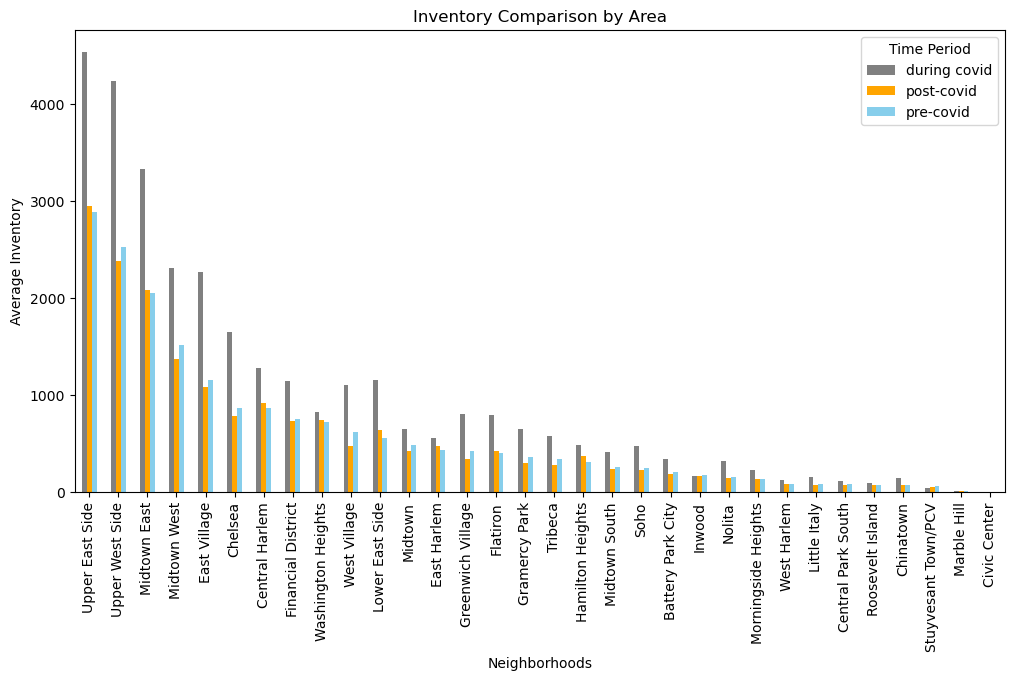

In [196]:
grouped_precovid = pre_covid_rent_inv.groupby(['areaName']).mean('Inventory').sort_values('Inventory').reset_index()
grouped_precovid['period'] = 'pre-covid'
grouped_covid = covid_rent_inv.groupby(['areaName']).mean('Inventory').sort_values('Inventory').reset_index()
grouped_covid['period'] = 'during covid'
grouped_postcovid = post_covid_rent_inv.groupby(['areaName']).mean('Inventory').sort_values('Inventory').reset_index()
grouped_postcovid['period'] = 'post-covid'
grouped = pd.concat([grouped_precovid, grouped_covid, grouped_postcovid]).reset_index()

pivot_df = grouped.pivot(index='areaName', columns='period', values='Inventory').sort_values('pre-covid', ascending=False)

# Plotting
pivot_df.plot(kind='bar', color=['grey', 'orange', 'skyblue'], figsize=(12, 6))
plt.title('Inventory Comparison by Area')
plt.xlabel('Neighborhoods')
plt.ylabel('Average Inventory')
plt.xticks(rotation='vertical')
plt.legend(title='Time Period')
# plt.tight_layout()
plt.show()

In [191]:
pivot_df

period,during covid,post-covid,pre-covid
areaName,,,
Battery Park City,337.2,187.708333,208.461538
Central Harlem,1275.3,917.458333,861.384615
Central Park South,111.0,72.541667,78.730769
Chelsea,1647.0,786.208333,862.730769
Chinatown,147.8,76.583333,74.038462
Civic Center,0.7,0.208333,1.076923
East Harlem,553.8,471.041667,435.538462
East Village,2268.0,1085.791667,1156.576923
Financial District,1146.2,733.208333,750.576923


In [195]:
# submarket area type

# Use the function to get a new DataFrame
manhattan_submarkets = clean_dataframe(rental_inventory_df)

# Keep only the 'submarket' areaType
manhattan_submarkets = manhattan_submarkets[manhattan_submarkets['areaType'] == 'submarket'].reset_index(drop=True)

# Separate submarkets for before, during, and post covid
pre_covid_submarket = manhattan_submarkets[manhattan_submarkets['Date'].between("2018-01-01", "2020-02-01")]
covid_submarket = manhattan_submarkets[manhattan_submarkets['Date'].between("2020-03-01", "2020-12-01")]
post_covid_submarket = manhattan_submarkets[manhattan_submarkets['Date'].between("2021-01-01", "2022-12-01")]

pre_covid_submarket['Quarter'] = pre_covid_submarket['Date'].quarter

pre_covid_submarket

AttributeError: 'Series' object has no attribute 'quarter'

In [187]:
grouped_sub_precovid = pre_covid_submarket.groupby(['areaName', 'Date']).mean('Inventory').reset_index()
grouped_sub_precovid['period'] = 'pre-covid'
grouped_sub_covid = covid_submarket.groupby(['areaName', 'Date']).mean('Inventory').reset_index()
grouped_sub_covid['period'] = 'during covid'
grouped_sub_postcovid = post_covid_submarket.groupby(['areaName', 'Date']).mean('Inventory').reset_index()
grouped_sub_postcovid['period'] = 'post-covid'
grouped_submarkets = pd.concat([grouped_sub_precovid, grouped_sub_covid, grouped_sub_postcovid]).reset_index()

grouped_sub_precovid

,areaName,Date,Inventory,period
0,All Downtown,2018-01-01,5939.0,pre-covid
1,All Downtown,2018-02-01,5638.0,pre-covid
2,All Downtown,2018-03-01,6139.0,pre-covid
3,All Downtown,2018-04-01,6847.0,pre-covid
4,All Downtown,2018-05-01,7641.0,pre-covid
...,...,...,...,...
125,All Upper West Side,2019-10-01,2203.0,pre-covid
126,All Upper West Side,2019-11-01,1999.0,pre-covid
127,All Upper West Side,2019-12-01,1848.0,pre-covid
128,All Upper West Side,2020-01-01,2021.0,pre-covid


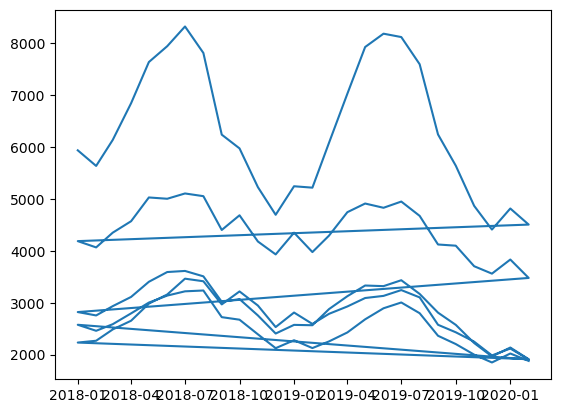

In [188]:
plt.plot(grouped_sub_precovid['Date'], grouped_sub_precovid['Inventory'])

plt.show()